# Machine Learning for Level Truncation in Open String Field Theory

Harold Erbin, Riccardo Finotello, Matej Kudrna, Martin Schnabl

---
---

## Abstract

In the framework of bosonic Open String Field Theory (OSFT), we consider several observables characterised by conformal weight and type, and the position of vacua in the potential for various values of truncated mass level. We focus on the prediction of the extrapolated value for the level-$\infty$ truncation using Machine Learning (ML) techniques.

In this notebook we focus on predictions of the $\mathrm{SU}(2)$ WZW model using a neural network.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf

# set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
import numpy as np

RAND = 123
np.random.seed(RAND)
tf.random.set_seed(RAND)

## Load the Dataset

As a first step we reload the full dataset used for the EDA:

In [4]:
import pandas as pd

# load the dataset
df = pd.read_csv('./data/data_wzw.csv')

In [5]:
import os
os.makedirs('./models', exist_ok=True)

## Validation Strategy

We then retain 10% of the total dataset as test set (that means that we may have to keep less unique solutions than that), 10% as validation set and the rest for training.

In [6]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.1, shuffle=True, random_state=RAND)
df_train, df_val  = train_test_split(df_train ,test_size=1/9, shuffle=False)

# print statistics
print('Fraction of samples in the training set: {:.2f}.'.format(df_train.shape[0] / df.shape[0]))
print('Fraction of samples in the validation set: {:.2f}.'.format(df_val.shape[0] / df.shape[0]))
print('Fraction of samples in the test set: {:.2f}.'.format(df_test.shape[0] / df.shape[0]))

Fraction of samples in the training set: 0.80.
Fraction of samples in the validation set: 0.10.
Fraction of samples in the test set: 0.10.


In [7]:
df.columns

Index(['k', 'exp_re', 'exp_im', 'weight', 'j', 'm', 'type', 'level_2_re',
       'level_2_im', 'level_3_re', 'level_3_im', 'level_4_re', 'level_4_im',
       'level_5_re', 'level_5_im', 'level_6_re', 'level_6_im', 'level_7_re',
       'level_7_im', 'level_8_re', 'level_8_im', 'level_9_re', 'level_9_im',
       'level_10_re', 'level_10_im'],
      dtype='object')

We then scale the input data using a `RobustScaler` on the truncation levels.

In [8]:
import sklearn
from sklearn.preprocessing import RobustScaler
import joblib

def rescale(df: pd.DataFrame,
            scl: sklearn.base.BaseEstimator,
            train: bool = False
           ) -> pd.DataFrame:
    '''
    Rescale the truncation levels only.
    
    Required arguments:
        df:    the dataframe,
        scl:   the scaler,
        train: whether df is training set.
        
    Returns:
        the scaler and the scaled dataframe.
    '''
    df_p1 = df[['weight', 'type', 'k', 'j', 'm']]
    df_p2 = df.filter(regex='^level_.*')
    
    if train:
        df_p2 = pd.DataFrame(scaler.fit_transform(df_p2), columns=df_p2.columns)
    else:
        df_p2 = pd.DataFrame(scaler.transform(df_p2), columns=df_p2.columns)
        
    # reset indices
    df_p1 = df_p1.reset_index(drop=True)
    df_p2 = df_p2.reset_index(drop=True)
        
    df = pd.concat([df_p1, df_p2], axis=1)
    
    return scaler, df

# save the labels to file
lab_train = df_train[['exp_re', 'exp_im']]
lab_train.to_csv('./data/lab_train.csv', index=False)
lab_val = df_val[['exp_re', 'exp_im']]
lab_val.to_csv('./data/lab_val.csv', index=False)
lab_test = df_test[['exp_re', 'exp_im']]
lab_test.to_csv('./data/lab_test.csv', index=False)

# save the sets to file after scaling
scaler = RobustScaler()

# drop the columns and shuffle the content
df_train         = df_train.drop(columns=['exp_re', 'exp_im'])
scaler, df_train = rescale(df_train, scaler, train=True)
#df_train         = df_train.sample(frac=1, random_state=RAND)
df_train.to_csv('./data/train.csv', index=False)

# save the trained scaler
joblib.dump(scaler, './models/scaler.pkl')

# do the same for validation and test sets
df_val    = df_val.drop(columns=['exp_re', 'exp_im'])
_, df_val = rescale(df_val, scaler, train=False)
#df_val    = df_val.sample(frac=1, random_state=RAND)
df_val.to_csv('./data/val.csv', index=False)

df_test    = df_test.drop(columns=['exp_re', 'exp_im'])
_, df_test = rescale(df_test, scaler, train=False)
#df_test    = df_test.sample(frac=1, random_state=RAND)
df_test.to_csv('./data/test.csv', index=False)

Set useful constants:

In [9]:
TRAIN = './data/train.csv'
VAL   = './data/val.csv'
TEST = './data/test.csv'

LAB_TRAIN = './data/lab_train.csv'
LAB_VAL   = './data/lab_val.csv'
LAB_TEST   = './data/lab_test.csv'

## Artificial Neural Networks

As a final model we use a simple fully connected (FC) ANN to predict the labels.

In [10]:
input_shape=df_train.shape[1:]

In [11]:
from tensorflow       import keras
from tensorflow.keras import layers, \
                             initializers, \
                             optimizers, \
                             regularizers, \
                             losses, \
                             metrics
from sklearn.metrics  import mean_squared_error, \
                             mean_absolute_error, \
                             r2_score


from tensorflow.keras.models import save_model

# clear leftover sessions
keras.backend.clear_session()

# build shortcuts to include layers
denser   = lambda n: layers.Dense(n,
                                  activation='relu',
                                  kernel_initializer=initializers.glorot_uniform(RAND),
                                  bias_initializer=tf.zeros_initializer(),
                                  activity_regularizer=regularizers.l2(5.0e-3)
                                 )
dropper  = lambda x: layers.Dropout(rate=x, seed=RAND)
outputer = lambda n, s: layers.Dense(n,
                                     name='output_' + s,
                                     kernel_initializer=initializers.glorot_uniform(RAND),
                                     bias_initializer=tf.zeros_initializer(),
                                     activity_regularizer=regularizers.l2(5.0e-3)
                                    )

# build the model
I = layers.Input(shape=input_shape)

x = denser(30)(I)
x = layers.BatchNormalization()(x)
x = dropper(0.01)(x)

x = denser(20)(x)
x = layers.BatchNormalization()(x)
x = dropper(0.01)(x)

x = denser(10)(x)
x = layers.BatchNormalization()(x)
x = dropper(0.01)(x)

x = denser(10)(x)
x = layers.BatchNormalization()(x)

re = outputer(1, 're')(x)
im = outputer(1, 'im')(x)

output = {'re': re,
          'im': im
         }
weights = {'re': 0.5,
           'im': 0.5
          }

ann_mod = keras.models.Model(inputs=I, outputs=output, name='sft-trunc-wzw')

# compile the model
ann_mod.compile(optimizer=optimizers.Adam(learning_rate=0.01),
                loss='mse',
                loss_weights=weights,
                metrics=['mse', 'mae']
               )

ann_mod.summary()

# save the model
ANN_MODEL = './models/ann.h5'
save_model(ann_mod, ANN_MODEL)

Model: "sft-trunc-wzw"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 23)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           720         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 30)           120         dense[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 30)           0           batch_normalization[0][0]        
______________________________________________________________________________________

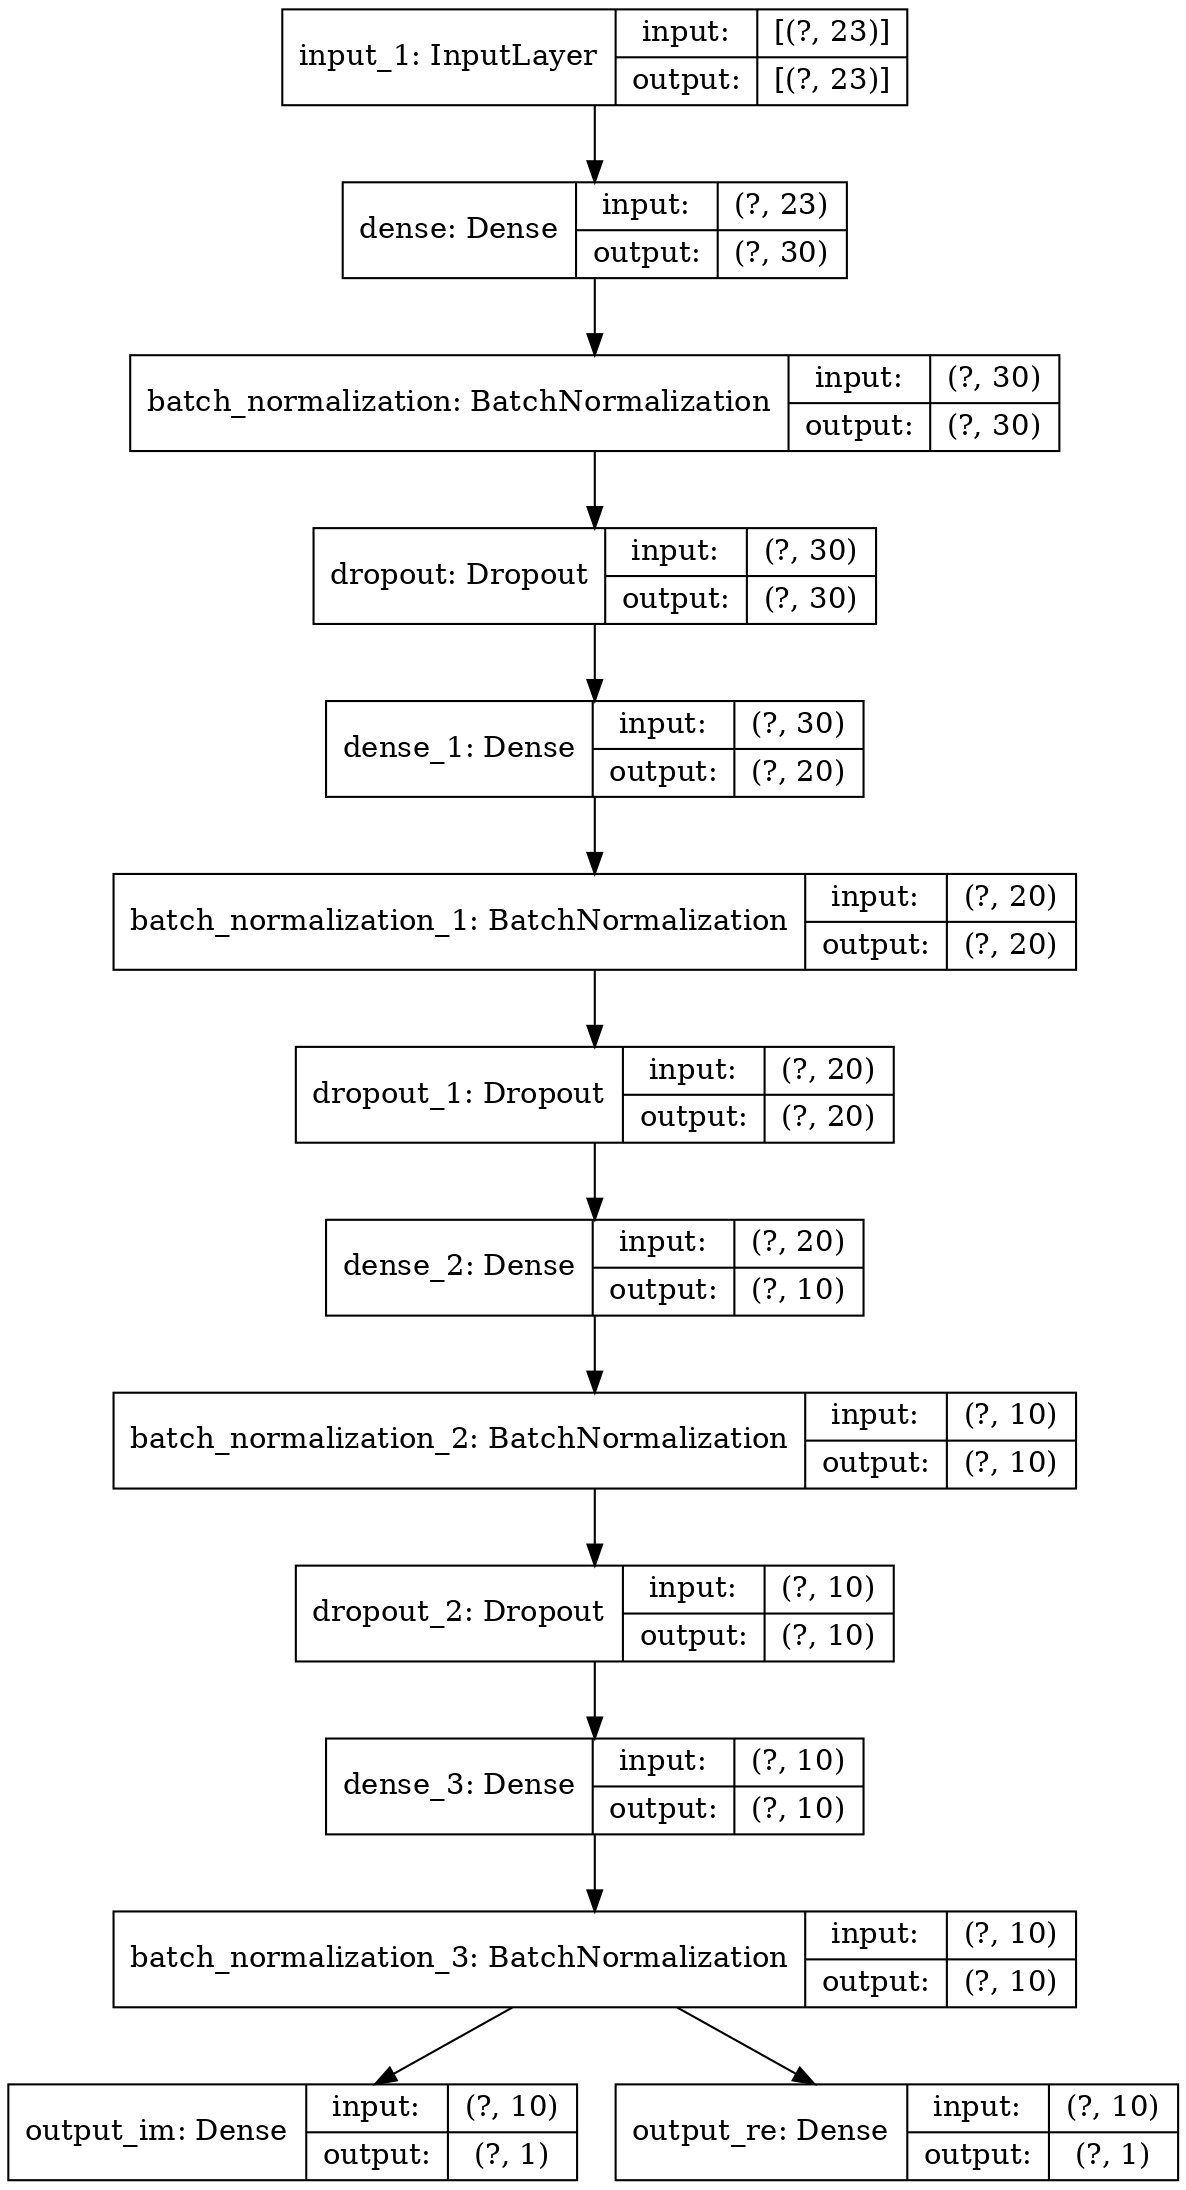

In [12]:
from tensorflow.keras.utils import model_to_dot
from IPython.display import Image

ann_mod_dot = model_to_dot(ann_mod, show_shapes=True, dpi=150)
ann_mod_dot.write_pdf('./img/ann_mod_arch.pdf')

Image(ann_mod_dot.create_png(), width=480)

We then fit the model on the data:

In [13]:
TRAIN = './data/train.csv'
VAL   = './data/val.csv'

LAB_TRAIN = './data/lab_train.csv'
LAB_VAL   = './data/lab_val.csv'

ANN_MODEL = './models/ann.h5'
EPOCHS    = 25000
BATCH     = 32
EARLYSTOP = 5000
PLATEAU   = 2500

RAND = 123

!python3 ./scripts/keras-train.py -t {TRAIN} -lt {LAB_TRAIN} \
                                  -v {VAL} -lv {LAB_VAL} \
                                  -e {EPOCHS} -b {BATCH} \
                                  -s {EARLYSTOP} -p {PLATEAU} \
                                  -m {ANN_MODEL} -r {RAND}

Model trained in 1908.439 seconds.


Finally we compute metrics and predictions:

In [14]:
TEST = './data/test.csv'
LAB_TEST = './data/lab_test.csv'

ANN_MODEL = './models/ann.h5'

OUTPUT_TRAIN = 'ann_model_train'
OUTPUT_VAL   = 'ann_model_val'
OUTPUT_TEST  = 'ann_model_test'

!python3 ./scripts/keras-predict.py -t {TRAIN} -l {LAB_TRAIN} -m {ANN_MODEL} -o {OUTPUT_TRAIN}
!python3 ./scripts/keras-predict.py -t {VAL} -l {LAB_VAL} -m {ANN_MODEL} -o {OUTPUT_VAL}
!python3 ./scripts/keras-predict.py -t {TEST} -l {LAB_TEST} -m {ANN_MODEL} -o {OUTPUT_TEST}

Model predicted in 0.309 seconds.
Model predicted in 0.286 seconds.
Model predicted in 0.287 seconds.


In [15]:
import json

print('Real part:')

with open('./metrics/{}_re.json'.format(OUTPUT_TRAIN, 'r')) as f:
    metrics_train = pd.DataFrame(json.load(f), index=[OUTPUT_TRAIN])
with open('./metrics/{}_re.json'.format(OUTPUT_VAL, 'r')) as f:
    metrics_val = pd.DataFrame(json.load(f), index=[OUTPUT_VAL])
with open('./metrics/{}_re.json'.format(OUTPUT_TEST, 'r')) as f:
    metrics_test = pd.DataFrame(json.load(f), index=[OUTPUT_TEST])
    
pd.concat([metrics_train, metrics_val, metrics_test])

Real part:


,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
ann_model_train,1321,0.013592,0.011046,0.016137,0.116583,0.072611,0.961513
ann_model_val,145,0.020924,0.010149,0.031699,0.144651,0.085763,0.943217
ann_model_test,145,0.114531,-0.069531,0.298593,0.338424,0.113950,0.663784


In [16]:
import json

print('Imaginary part:')

with open('./metrics/{}_im.json'.format(OUTPUT_TRAIN, 'r')) as f:
    metrics_train = pd.DataFrame(json.load(f), index=[OUTPUT_TRAIN])
with open('./metrics/{}_im.json'.format(OUTPUT_VAL, 'r')) as f:
    metrics_val = pd.DataFrame(json.load(f), index=[OUTPUT_VAL])
with open('./metrics/{}_im.json'.format(OUTPUT_TEST, 'r')) as f:
    metrics_test = pd.DataFrame(json.load(f), index=[OUTPUT_TEST])
    
pd.concat([metrics_train, metrics_val, metrics_test])

Imaginary part:


,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
ann_model_train,1321,0.005559,0.000629,0.010489,0.074560,0.029633,0.939314
ann_model_val,145,0.002693,0.001099,0.004287,0.051892,0.026825,0.957688
ann_model_test,145,0.065565,-0.049112,0.180242,0.256056,0.062383,0.302641


Finally we produce all the necessary plots and display them:

In [17]:
PREDS_VAL  = './predictions/{}.csv'.format(OUTPUT_VAL)
PREDS_TEST = './predictions/{}.csv'.format(OUTPUT_TEST)

OUTPUT_VAL  = 'ann_model_val'
OUTPUT_TEST = 'ann_model_test'

!python3 ./scripts/summary.py --data {PREDS_VAL} --output {OUTPUT_VAL}
!python3 ./scripts/summary.py --data {PREDS_TEST} --output {OUTPUT_TEST}

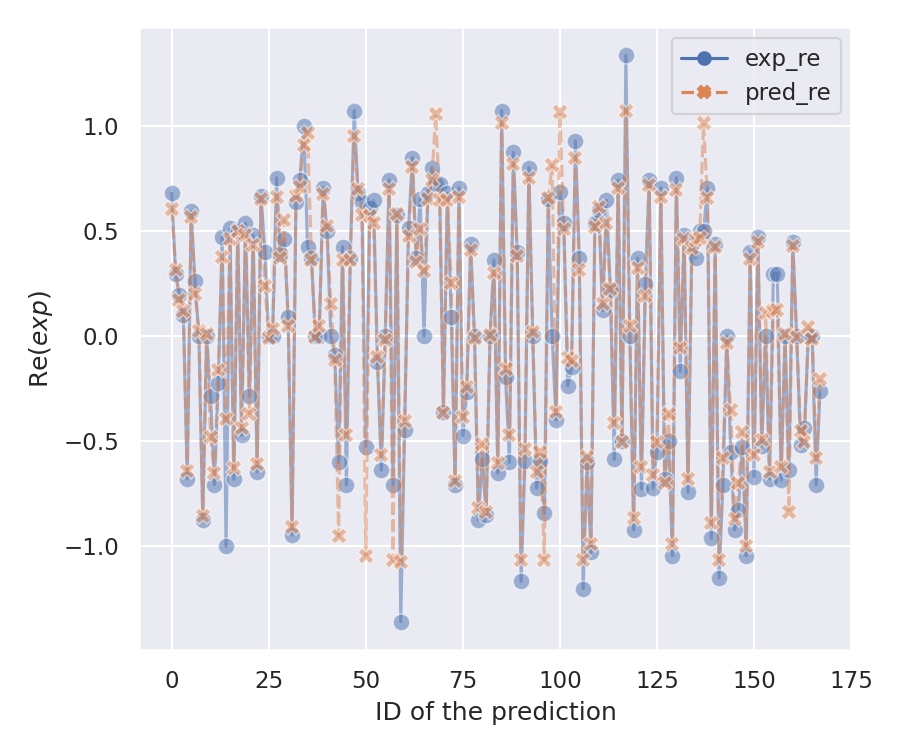

In [18]:
from IPython.display import Image
Image('./img/{}_re_lineplot.png'.format(OUTPUT_VAL), width=480)

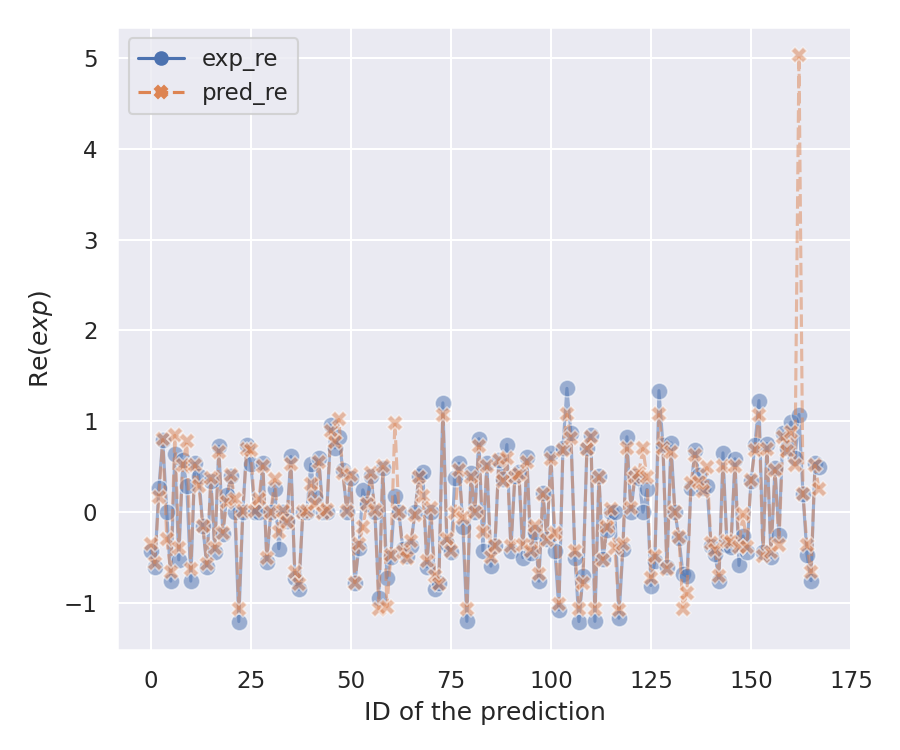

In [19]:
from IPython.display import Image
Image('./img/{}_re_lineplot.png'.format(OUTPUT_TEST), width=480)

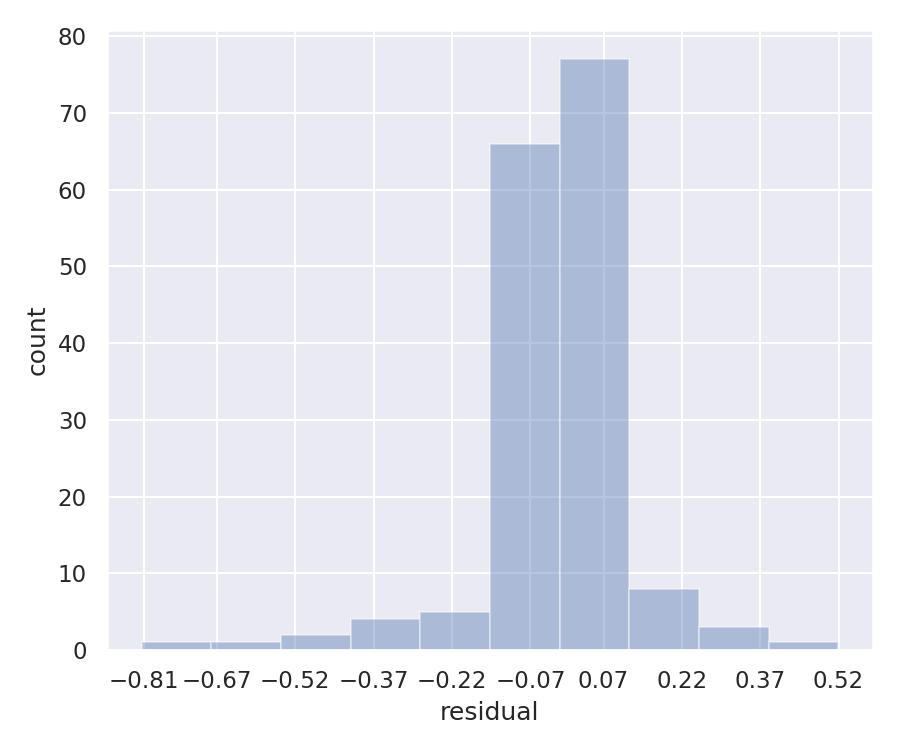

In [20]:
from IPython.display import Image
Image('./img/{}_re_histogram.png'.format(OUTPUT_VAL), width=480)

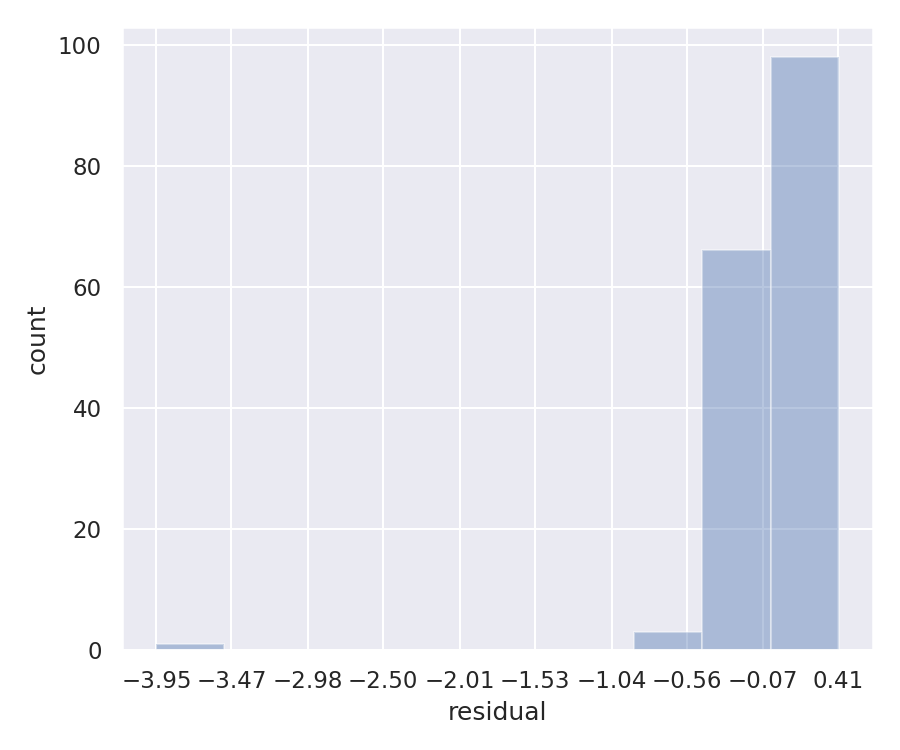

In [21]:
from IPython.display import Image
Image('./img/{}_re_histogram.png'.format(OUTPUT_TEST), width=480)

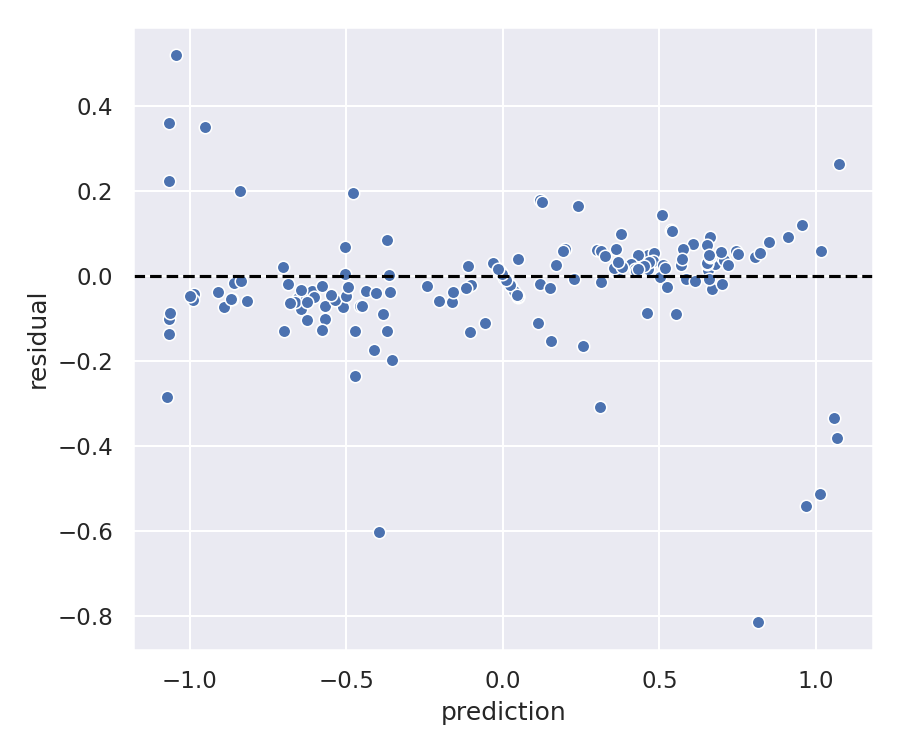

In [22]:
from IPython.display import Image
Image('./img/{}_re_resplot.png'.format(OUTPUT_VAL), width=480)

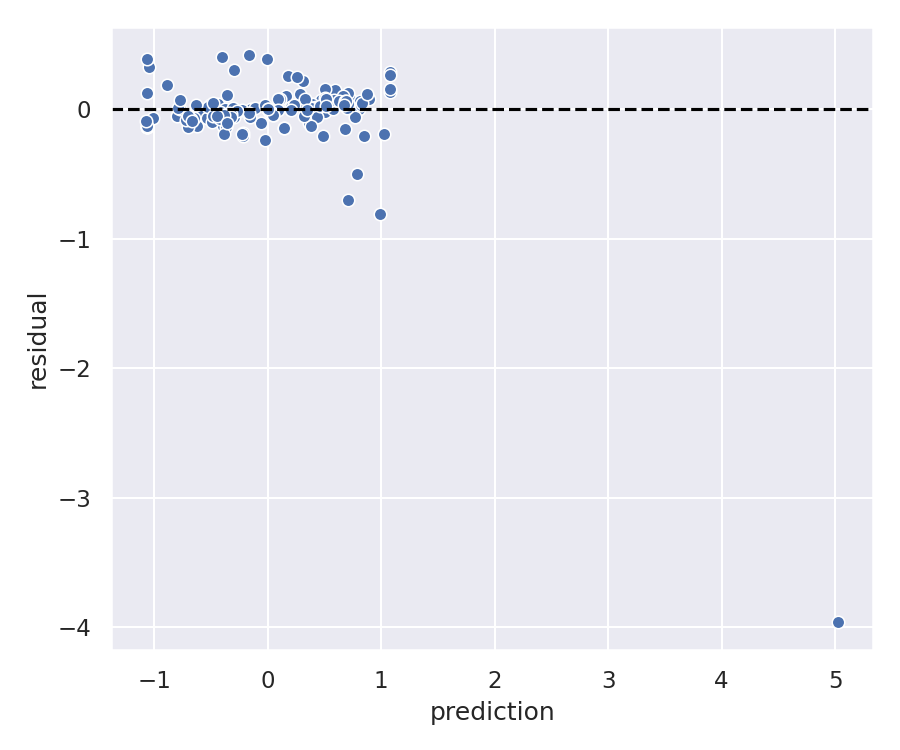

In [23]:
from IPython.display import Image
Image('./img/{}_re_resplot.png'.format(OUTPUT_TEST), width=480)

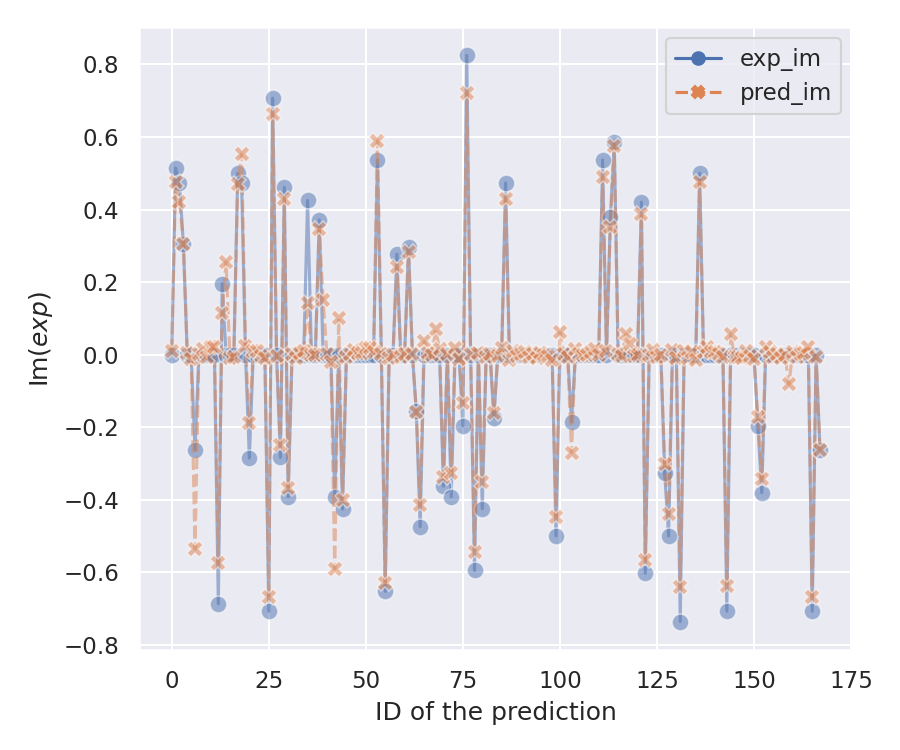

In [24]:
from IPython.display import Image
Image('./img/{}_im_lineplot.png'.format(OUTPUT_VAL), width=480)

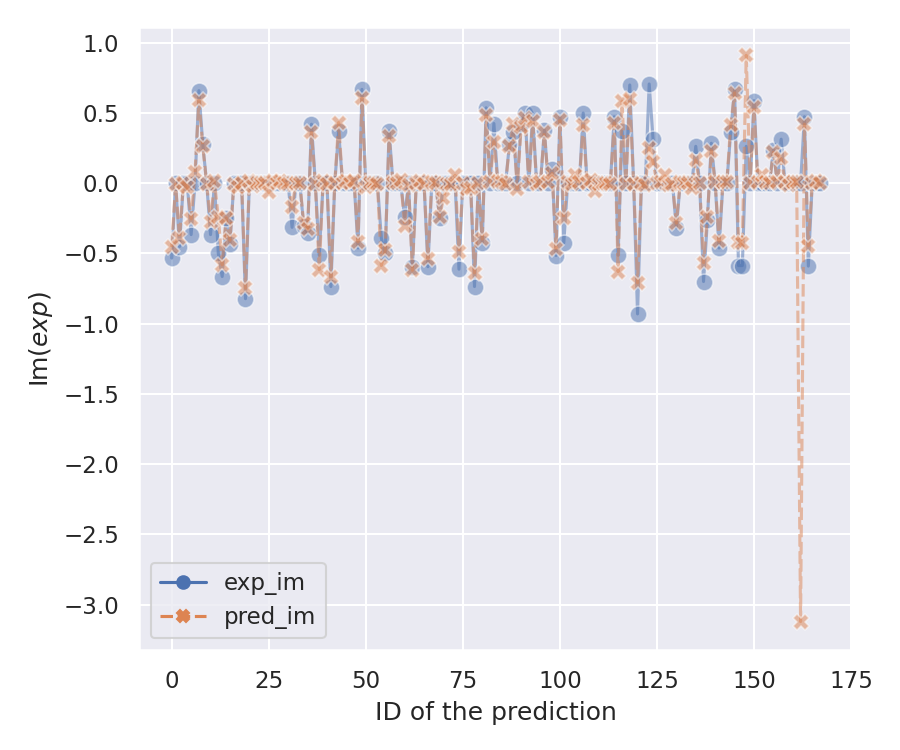

In [25]:
from IPython.display import Image
Image('./img/{}_im_lineplot.png'.format(OUTPUT_TEST), width=480)

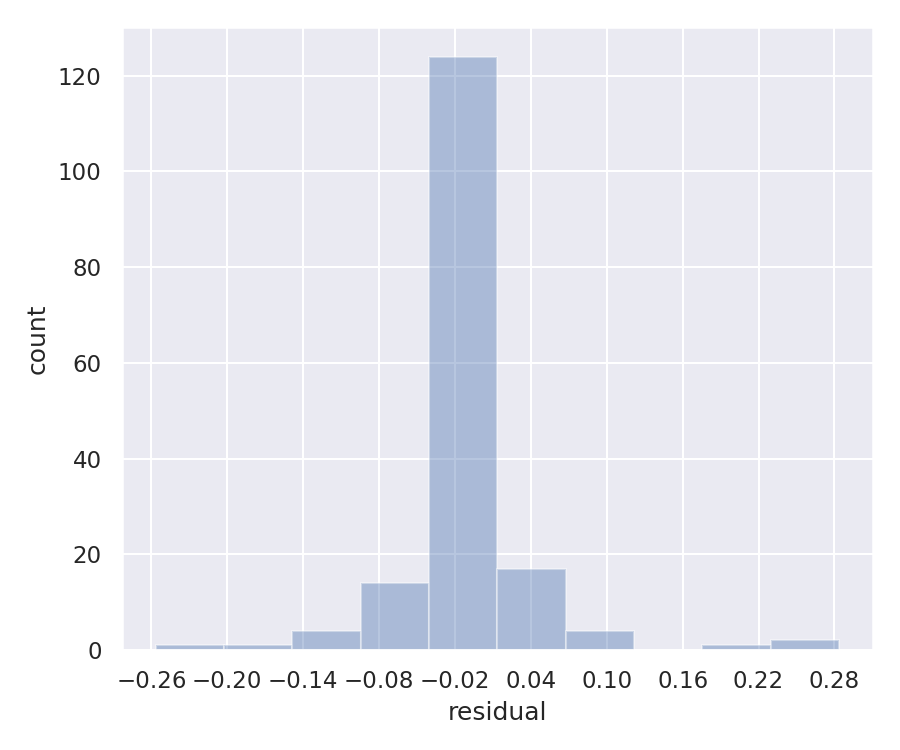

In [26]:
from IPython.display import Image
Image('./img/{}_im_histogram.png'.format(OUTPUT_VAL), width=480)

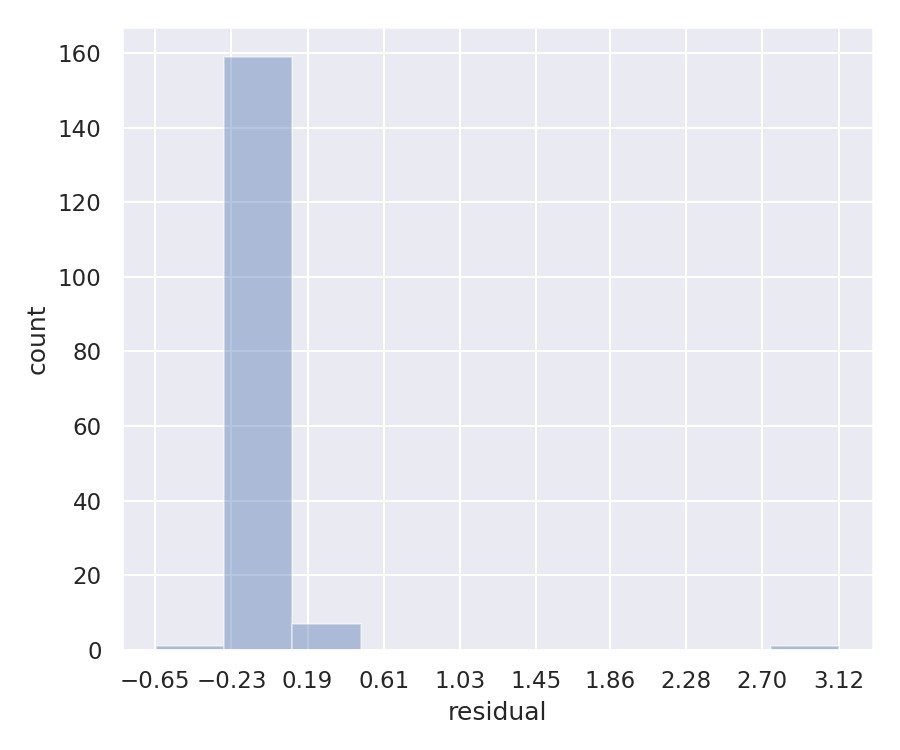

In [27]:
from IPython.display import Image
Image('./img/{}_im_histogram.png'.format(OUTPUT_TEST), width=480)

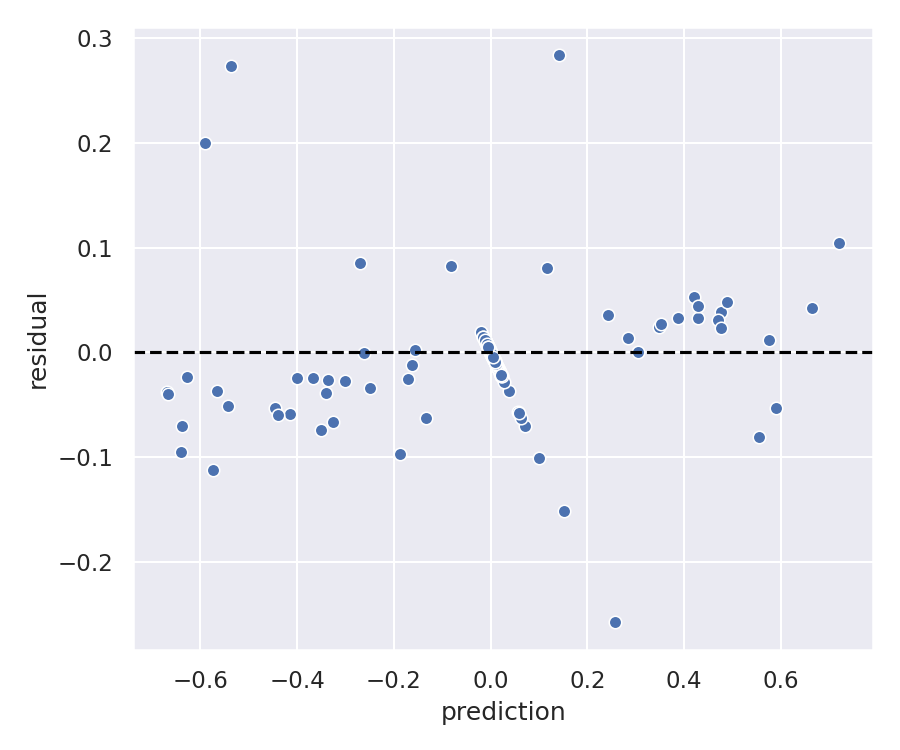

In [28]:
from IPython.display import Image
Image('./img/{}_im_resplot.png'.format(OUTPUT_VAL), width=480)

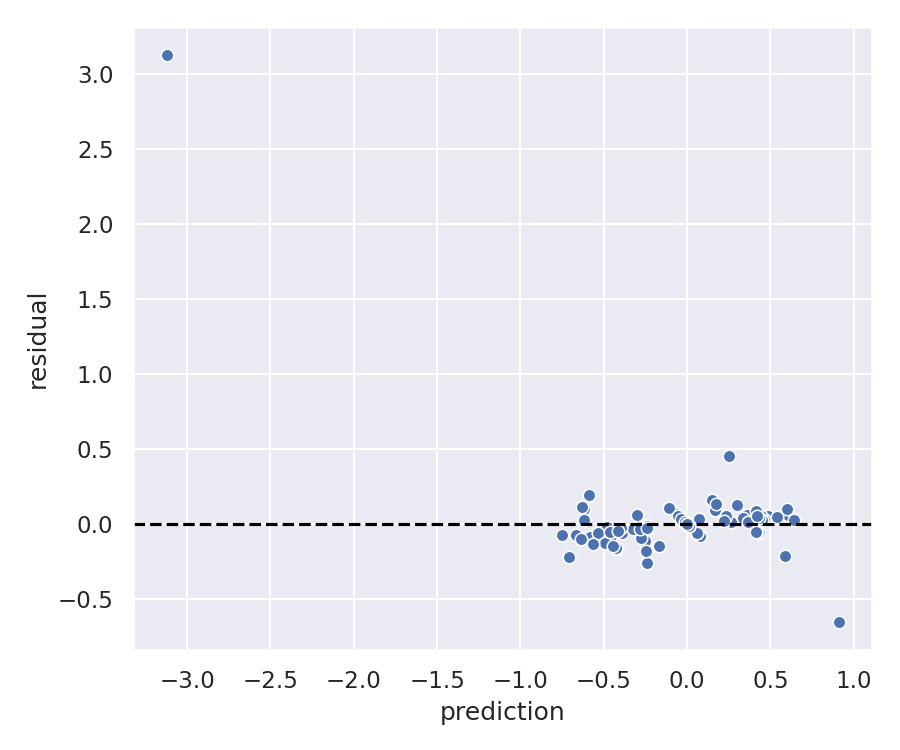

In [29]:
from IPython.display import Image
Image('./img/{}_im_resplot.png'.format(OUTPUT_TEST), width=480)

In [30]:
HISTORY = './models/ann_mod_hst.json'
OUTPUT  = 'ann_mod_hst'

!python3 ./scripts/keras-history.py --data {HISTORY} --output {OUTPUT}

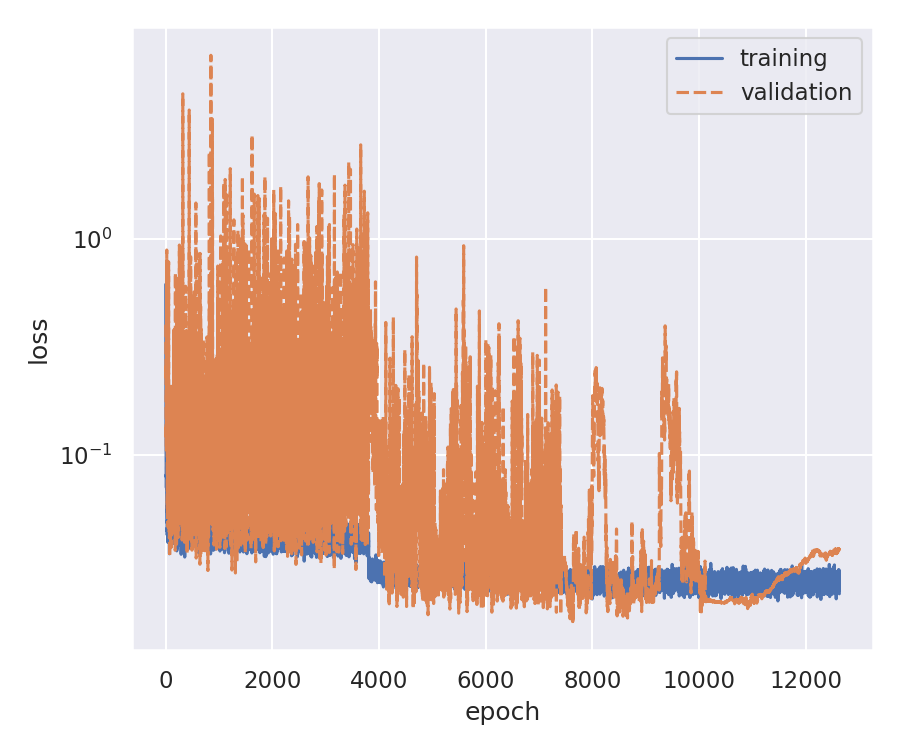

In [31]:
from IPython.display import Image
Image('./img/{}.png'.format(OUTPUT), width=480)

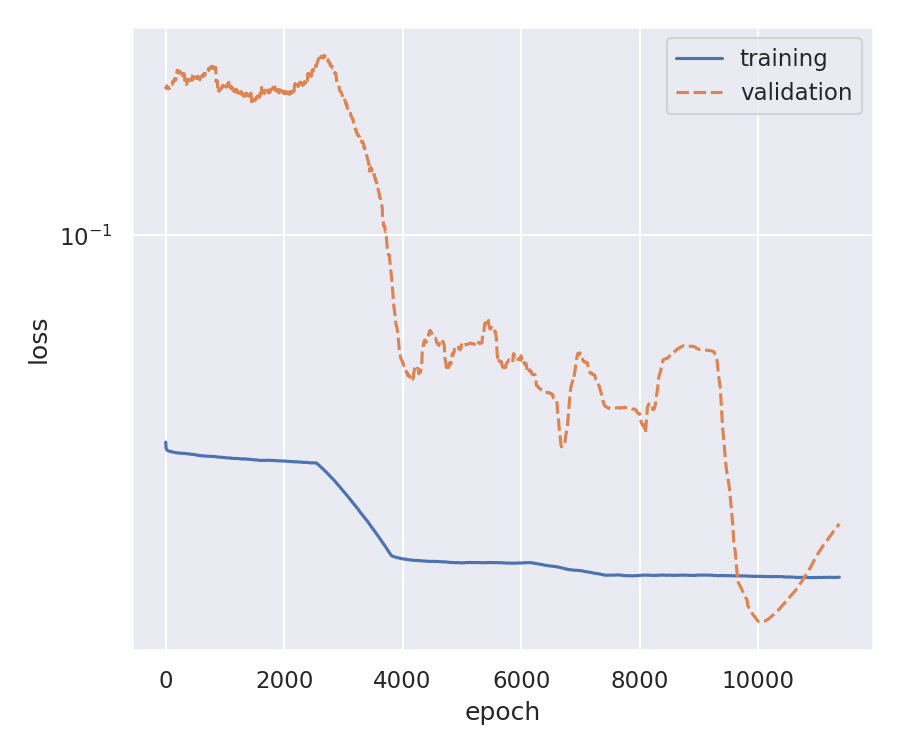

In [32]:
from IPython.display import Image
Image('./img/{}_avg.png'.format(OUTPUT), width=480)

We finally take a look at the learning curve:

In [33]:
DATA = './data/wzw_eda.csv'
OUTPUT = 'ann_mod_lc'

!python3 ./scripts/keras-lc.py -d {DATA} -m {ANN_MODEL} -e {EPOCHS} -b {BATCH} -s {EARLYSTOP} -p {PLATEAU} -o {OUTPUT}

Trained ratio 0.10 in 655.283 seconds.
Trained ratio 0.20 in 725.482 seconds.
Trained ratio 0.30 in 765.088 seconds.
Trained ratio 0.40 in 814.520 seconds.
Trained ratio 0.50 in 882.056 seconds.
Trained ratio 0.60 in 930.298 seconds.
Trained ratio 0.70 in 760.045 seconds.
Trained ratio 0.80 in 1101.045 seconds.
Trained ratio 0.90 in 2079.514 seconds.
Learning curve trained in 8716.189 seconds.


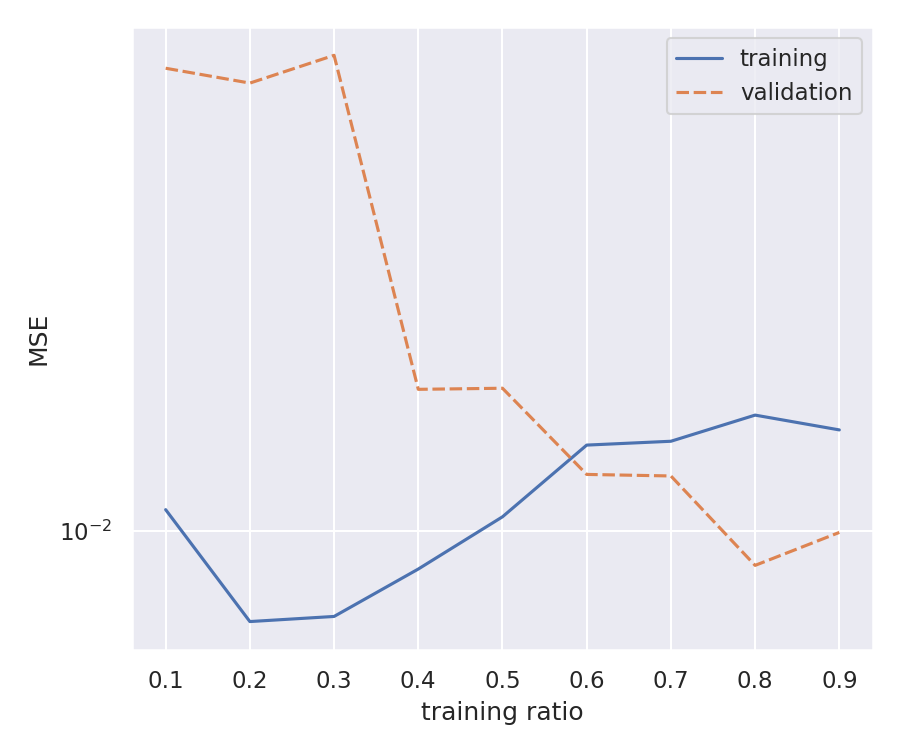

In [34]:
from IPython.display import Image
Image('./img/{}.png'.format(OUTPUT), width=480)